In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from vep_tools import VEPAnalysisTools
from ssvep_tools import SSVEPAnalysisTools  

from main import load_eeg_data, check_equal_length, find_increasing_indices, calculate_diff_list

In [5]:
"""
Load EEG data from a text file.

Parameters:
file_path (str): Path to the text file containing EEG data.
mode (str): The type of data being loaded, 'VEP' or 'SSVEP'.

Returns:
list: A list of NumPy arrays, each representing a channel.
"""
eeg_data = pd.read_csv("test_data2.txt", delimiter="\t", skiprows=12)

eeg_data

# # Make sure these indices match the actual columns in your CSV file
array_1 = np.array(eeg_data.iloc[:, 0])  # Adjust these indices based on actual column positions
array_2 = np.array(eeg_data.iloc[:, 1])
array_3 = np.array(eeg_data.iloc[:, 2])

print(len(array_1), len(array_2), len(array_3))



5309625 5309625 5309625


In [6]:
eeg_data = pd.read_csv("test_data.txt", delimiter="	", skiprows=10)

In [7]:
eeg_data.head()

,12000002 samples,12000002 samples.1,Unnamed: 2
0,-10.5133,0.0,NaN
1,-10.5286,0.0,NaN
2,-10.5438,0.0,NaN
3,-10.5591,0.0,NaN
4,-10.5743,0.0,NaN


In [8]:
# Extracting each column into a NumPy array
array_1 = np.array(eeg_data['12000002 samples'])
array_2 = np.array(eeg_data['12000002 samples.1'])

In [9]:
list_channels

NameError: name 'list_channels' is not defined

In [10]:
list_channels = [array_1, array_2]

# Function to check if all arrays have the same length
def check_equal_length(arrays):
    if not arrays:
        return False
    first_length = len(arrays[0])
    return all(len(arr) == first_length for arr in arrays)

# Check if all arrays in list_channels have the same length
if check_equal_length(list_channels):
    num_channels = len(list_channels)
    print(f"Number of channels: {num_channels}")
else:
    print("Error: Not all arrays have the same length.")


Number of channels: 2


In [11]:
# Function to find indices where the previous value is less than the current value
def find_increasing_indices(arr):
    prev = np.roll(arr, 1)
    prev[0] = np.nan  # Replace the first element as there's no previous element
    indices = np.where(prev < arr)[0]
    return indices

# Applying the function to the first array in list_channels
indices = find_increasing_indices(list_channels[1])
#indices

In [12]:
# Calculate the difference between consecutive indices
diff_list = []
prev = indices[0]
for j in range(1, len(indices)):
    diff = indices[j] - prev
    prev = indices[j]
    diff_list.append(diff)

size_row = min(diff_list)  # You can adjust this based on your needs
size_col = len(diff_list)
print(size_row, size_col)

25000 479


In [13]:
# Initialize an array with zeros based on size_row and size_col
array_of_values = np.zeros((size_row, size_col))

# Extract a subset of the original array using the calculated indices
# Note: Adjusting the subset extraction logic based on indices
eeg_data = list_channels[0][indices[0]:indices[0] + size_row]

In [14]:
eeg_data

array([-10.7422, -10.7574, -10.7727, ..., -12.619 , -12.6343, -12.6495])

In [15]:
# Extract the relevant portion of the array
eeg_data = list_channels[0][indices[0]:]

# Calculate number of columns for reshaping
n_col = len(eeg_data) / size_row

# Reshape the array
reshaped_eeg_array = eeg_data[:int(n_col) * size_row]
reshaped_eeg_array = reshaped_eeg_array.reshape(-1, size_row).transpose()

In [16]:
reshaped_eeg_array

array([[-10.7422  , -12.6648  ,  -0.808716, ...,  14.0991  ,  -4.28772 ,
         -2.73132 ],
       [-10.7574  , -12.6801  ,  -0.793457, ...,  14.1754  ,  -4.30298 ,
         -2.71606 ],
       [-10.7727  , -12.6801  ,  -0.778198, ...,  14.2517  ,  -4.30298 ,
         -2.70081 ],
       ...,
       [-12.619   ,  -0.854492,  11.1847  , ...,  -4.2572  ,  -2.76184 ,
         -1.32751 ],
       [-12.6343  ,  -0.839233,  11.2152  , ...,  -4.27246 ,  -2.74658 ,
         -1.297   ],
       [-12.6495  ,  -0.823975,  11.261   , ...,  -4.27246 ,  -2.74658 ,
         -1.28174 ]])

In [17]:
reshaped_eeg_row_mean = np.mean(reshaped_eeg_array, axis =1)
len(reshaped_eeg_row_mean)

25000

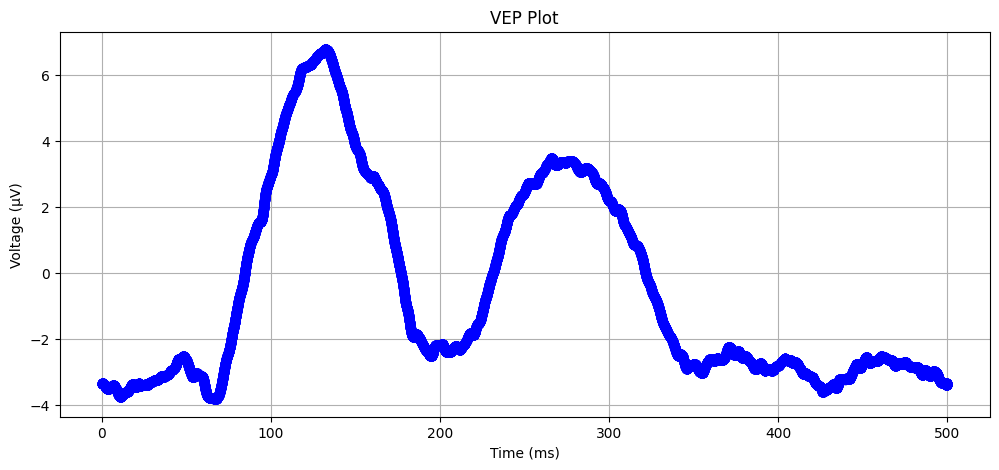

The latency of the maximum P100 amplitude is: 129.94 ms
The maximum P100 amplitude is: 6.675449133820457 µV
The latency of the maximum N75 amplitude is: 67.24000000000001 ms
The maximum N75 amplitude is: -3.834670337369523 µV
The latency of the maximum N135 amplitude is: 179.98 ms
The maximum N135 amplitude is: -0.9935736269311067 µV


In [20]:
# Function to find amplitude and latency
def find_amplitude_latency(data, time_vector, t_min, t_max, peak_type):
    start_idx = np.argmax(time_vector >= t_min)
    end_idx = np.argmax(time_vector >= t_max)
    sliced_data = data[start_idx:end_idx]
    time_slice = time_vector[start_idx:end_idx]
    
    if peak_type == "negative":
        peak_value = np.min(sliced_data)
        peak_idx = np.argmin(sliced_data)
    elif peak_type == "positive":
        peak_value = np.max(sliced_data)
        peak_idx = np.argmax(sliced_data)
    
    latency = time_slice[peak_idx]
    
    return peak_value, latency

# Function to plot VEP plot and display final text outputs
def plot_and_display(data, sampling_frequency):
    # Reshape the data
    reshaped_eeg_row_mean = data
    
    # Calculate the time vector
    length = len(reshaped_eeg_row_mean)
    time_vector = np.linspace(0, length / sampling_frequency, length, endpoint=False) * 1000
    
    # Plot the VEP Plot
    plt.figure(figsize=(12, 5))
    plt.plot(time_vector, reshaped_eeg_row_mean, marker='o', linestyle='-', color='b')
    plt.title("VEP Plot")
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (µV)")
    plt.grid(True)
    plt.show()

    # Find and display amplitude and latency for P100, N75, and N135
    t_P100_min, t_P100_max = 80, 130
    t_N75_min, t_N75_max = 55, 85
    t_N135_min, t_N135_max = 130, 180
    
    P100_value, latency_P100 = find_amplitude_latency(data, time_vector, t_P100_min, t_P100_max, "positive")
    N75_value, latency_N75 = find_amplitude_latency(data, time_vector, t_N75_min, t_N75_max, "negative")
    N135_value, latency_N135 = find_amplitude_latency(data, time_vector, t_N135_min, t_N135_max, "negative")
    
    # Display results
    print(f"The latency of the maximum P100 amplitude is: {latency_P100} ms")
    print(f"The maximum P100 amplitude is: {P100_value} µV")
    print(f"The latency of the maximum N75 amplitude is: {latency_N75} ms")
    print(f"The maximum N75 amplitude is: {N75_value} µV")
    print(f"The latency of the maximum N135 amplitude is: {latency_N135} ms")
    print(f"The maximum N135 amplitude is: {N135_value} µV")

# Call the function with your reshaped_eeg_row_mean data and sampling frequency
Fs =50000 # 50kHz sampling rate
plot_and_display(reshaped_eeg_row_mean, Fs)

In [21]:
# export results as txt

with open('results.txt', 'w', encoding='utf-8') as f:
    f.write('The maximum P100 amplitude is: ' + str(max_P100_value) + ' µV' + '\n')
    f.write('The latency of the maximum P100 amplitude is: ' + str(latency_P100) + ' ms' + '\n')

    f.write('The maximum N75 amplitude is: ' + str(max_N75_value) + ' µV' + '\n')
    f.write('The latency of the maximum N75 amplitude is: ' + str(latency_N75) + ' ms' + '\n')

    f.write('The maximum N135 amplitude is: ' + str(max_N135_value) + ' µV' + '\n')
    f.write('The latency of the maximum N135 amplitude is: ' + str(latency_N135) + ' ms' + '\n')

NameError: name 'max_P100_value' is not defined